<a href="https://colab.research.google.com/github/Sanjeeda-Jeba/ME-592-Spring2025/blob/main/ME592_Assignment2_robotics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
import os
import shutil
import os
import shutil

In [15]:

# Define paths
kaggle_path = "/root/.kaggle"
os.makedirs(kaggle_path, exist_ok=True)

# Move the uploaded file
shutil.move("/content/drive/MyDrive/Colab Notebooks/ME_592_A2/kaggle.json", os.path.join(kaggle_path, "kaggle.json"))

# Set correct permissions
os.chmod(os.path.join(kaggle_path, "kaggle.json"), 600)

print("Kaggle API setup complete!")




Kaggle API setup complete!


In [16]:
!kaggle datasets download -d oneoneliu/cornell-grasp --unzip

Dataset URL: https://www.kaggle.com/datasets/oneoneliu/cornell-grasp
License(s): unknown


In [24]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Task 1:
### Overlaying the positive and negative grasping rectangles on each image.

In [25]:
def parse_rectangles(file_path):
    rectangles = []
    with open(file_path, "r", encoding="latin-1") as f:
        lines = [line.strip() for line in f if line.strip()]

    if len(lines) % 4 != 0:
        print(f"Warning: {file_path} has a number of lines not multiple of 4.")

    for i in range(0, len(lines), 4):
        if i + 3 >= len(lines):
            break
        pts = []
        for j in range(4):
            line_str = lines[i+j]
            if "NaN" in line_str:
                print(f"Skipping line with NaN values: {line_str}")
                pts = []
                break

            parts = line_str.split()
            if len(parts) < 2:
                print("Skipping line with insufficient coordinates:", line_str)
                continue

            try:
                x = int(float(parts[0]))
                y = int(float(parts[1]))
            except Exception as e:
                print("Error converting coordinates:", e, "in line:", line_str)
                continue
            pts.append((x, y))

        if len(pts) == 4:
            rectangles.append(pts)

    return rectangles


In [26]:
def overlay_grasp_rectangles(image_path, pos_file, neg_file):

    rgb_image = cv2.imread(image_path)
    if rgb_image is None:
        print(f"Could not load image: {image_path}")
        return None

    positive_rectangles = parse_rectangles(pos_file) if os.path.exists(pos_file) else []
    negative_rectangles = parse_rectangles(neg_file) if os.path.exists(neg_file) else []

    # Overlay on a copy
    overlaid_img = rgb_image.copy()

    # Positive
    for rect in positive_rectangles:
        for i in range(4):
            cv2.line(overlaid_img, rect[i], rect[(i+1) % 4], (0, 255, 0), 2)

    # Negative
    for rect in negative_rectangles:
        for i in range(4):
            cv2.line(overlaid_img, rect[i], rect[(i+1) % 4], (0, 0, 255), 2)

    return overlaid_img



In [27]:
base_dir = "/content/"


subfolders = [f for f in sorted(os.listdir(base_dir))
              if os.path.isdir(os.path.join(base_dir, f)) and f.isdigit()]

all_overlaid_images = []

for sf in subfolders:
    folder_path = os.path.join(base_dir, sf)

    image_paths = glob.glob(os.path.join(folder_path, "*r.png"))

    for img_path in sorted(image_paths):

        base_name = os.path.basename(img_path)


        pos_file = os.path.join(folder_path, base_name.replace("r.png", "cpos.txt"))
        neg_file = os.path.join(folder_path, base_name.replace("r.png", "cneg.txt"))


        overlaid_img = overlay_grasp_rectangles(img_path, pos_file, neg_file)
        if overlaid_img is not None:
            all_overlaid_images.append((sf, base_name, overlaid_img))


Skipping line with NaN values: NaN NaN


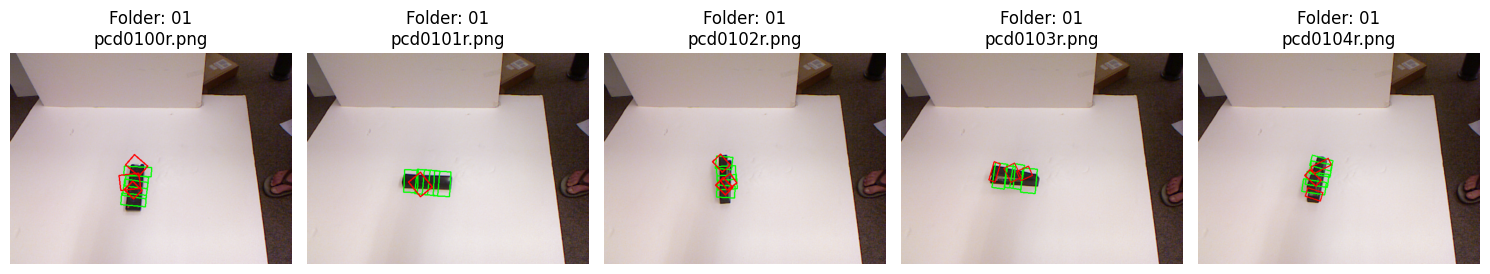

Processed 885 images in total.


In [28]:
num_to_show = min(5, len(all_overlaid_images))
if num_to_show == 0:
    print("No images to display.")
else:
    plt.figure(figsize=(15, 6))
    for i in range(num_to_show):
        sf, base_name, overlaid = all_overlaid_images[i]

        overlaid_rgb = cv2.cvtColor(overlaid, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_to_show, i + 1)
        plt.imshow(overlaid_rgb)
        plt.title(f"Folder: {sf}\n{base_name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

print(f"Processed {len(all_overlaid_images)} images in total.")

# Task 2:

In [29]:
def load_and_merge_rgb_depth(rgb_path, depth_path):

    rgb_image_bgr = cv2.imread(rgb_path)
    if rgb_image_bgr is None:
        print(f"[Skipping] Could not load color image: {rgb_path}")
        return None

    rgb_image = cv2.cvtColor(rgb_image_bgr, cv2.COLOR_BGR2RGB)

    try:
        depth_image = Image.open(depth_path)
        depth_image = np.array(depth_image)
    except Exception as e:
        print(f"[Skipping] Could not load depth image: {depth_path} ({e})")
        return None


    depth_image_norm = cv2.normalize(depth_image, None, 0, 255, cv2.NORM_MINMAX)
    depth_image_norm = depth_image_norm.astype(np.uint8)


    h_rgb, w_rgb, _ = rgb_image.shape
    h_d, w_d = depth_image_norm.shape
    if (h_rgb != h_d) or (w_rgb != w_d):
        print(f"[Info] Resizing depth from ({h_d}, {w_d}) to ({h_rgb}, {w_rgb})")
        depth_image_norm = cv2.resize(depth_image_norm, (w_rgb, h_rgb))

    rgbd_image = np.dstack((rgb_image, depth_image_norm))
    return rgbd_image

In [30]:
all_rgbd_images = []

for sf in subfolders:
    folder_path = os.path.join(base_dir, sf)
    print(f"\nProcessing folder: {folder_path}")

    rgb_paths = glob.glob(os.path.join(folder_path, "*r.png"))
    rgb_paths.sort()

    for rgb_path in rgb_paths:

        depth_path = rgb_path.replace("r.png", "d.tiff")

        if not os.path.exists(depth_path):
            print(f"[Skipping] No depth file for {rgb_path}")
            continue


        rgbd_image = load_and_merge_rgb_depth(rgb_path, depth_path)
        if rgbd_image is not None:
            base_name = os.path.basename(rgb_path)
            all_rgbd_images.append((sf, base_name, rgbd_image))

print(f"\nTotal RGB-D images created: {len(all_rgbd_images)}")



Processing folder: /content/01

Processing folder: /content/02

Processing folder: /content/03

Processing folder: /content/04

Processing folder: /content/05

Processing folder: /content/06

Processing folder: /content/07

Processing folder: /content/08

Processing folder: /content/09

Processing folder: /content/10

Total RGB-D images created: 885


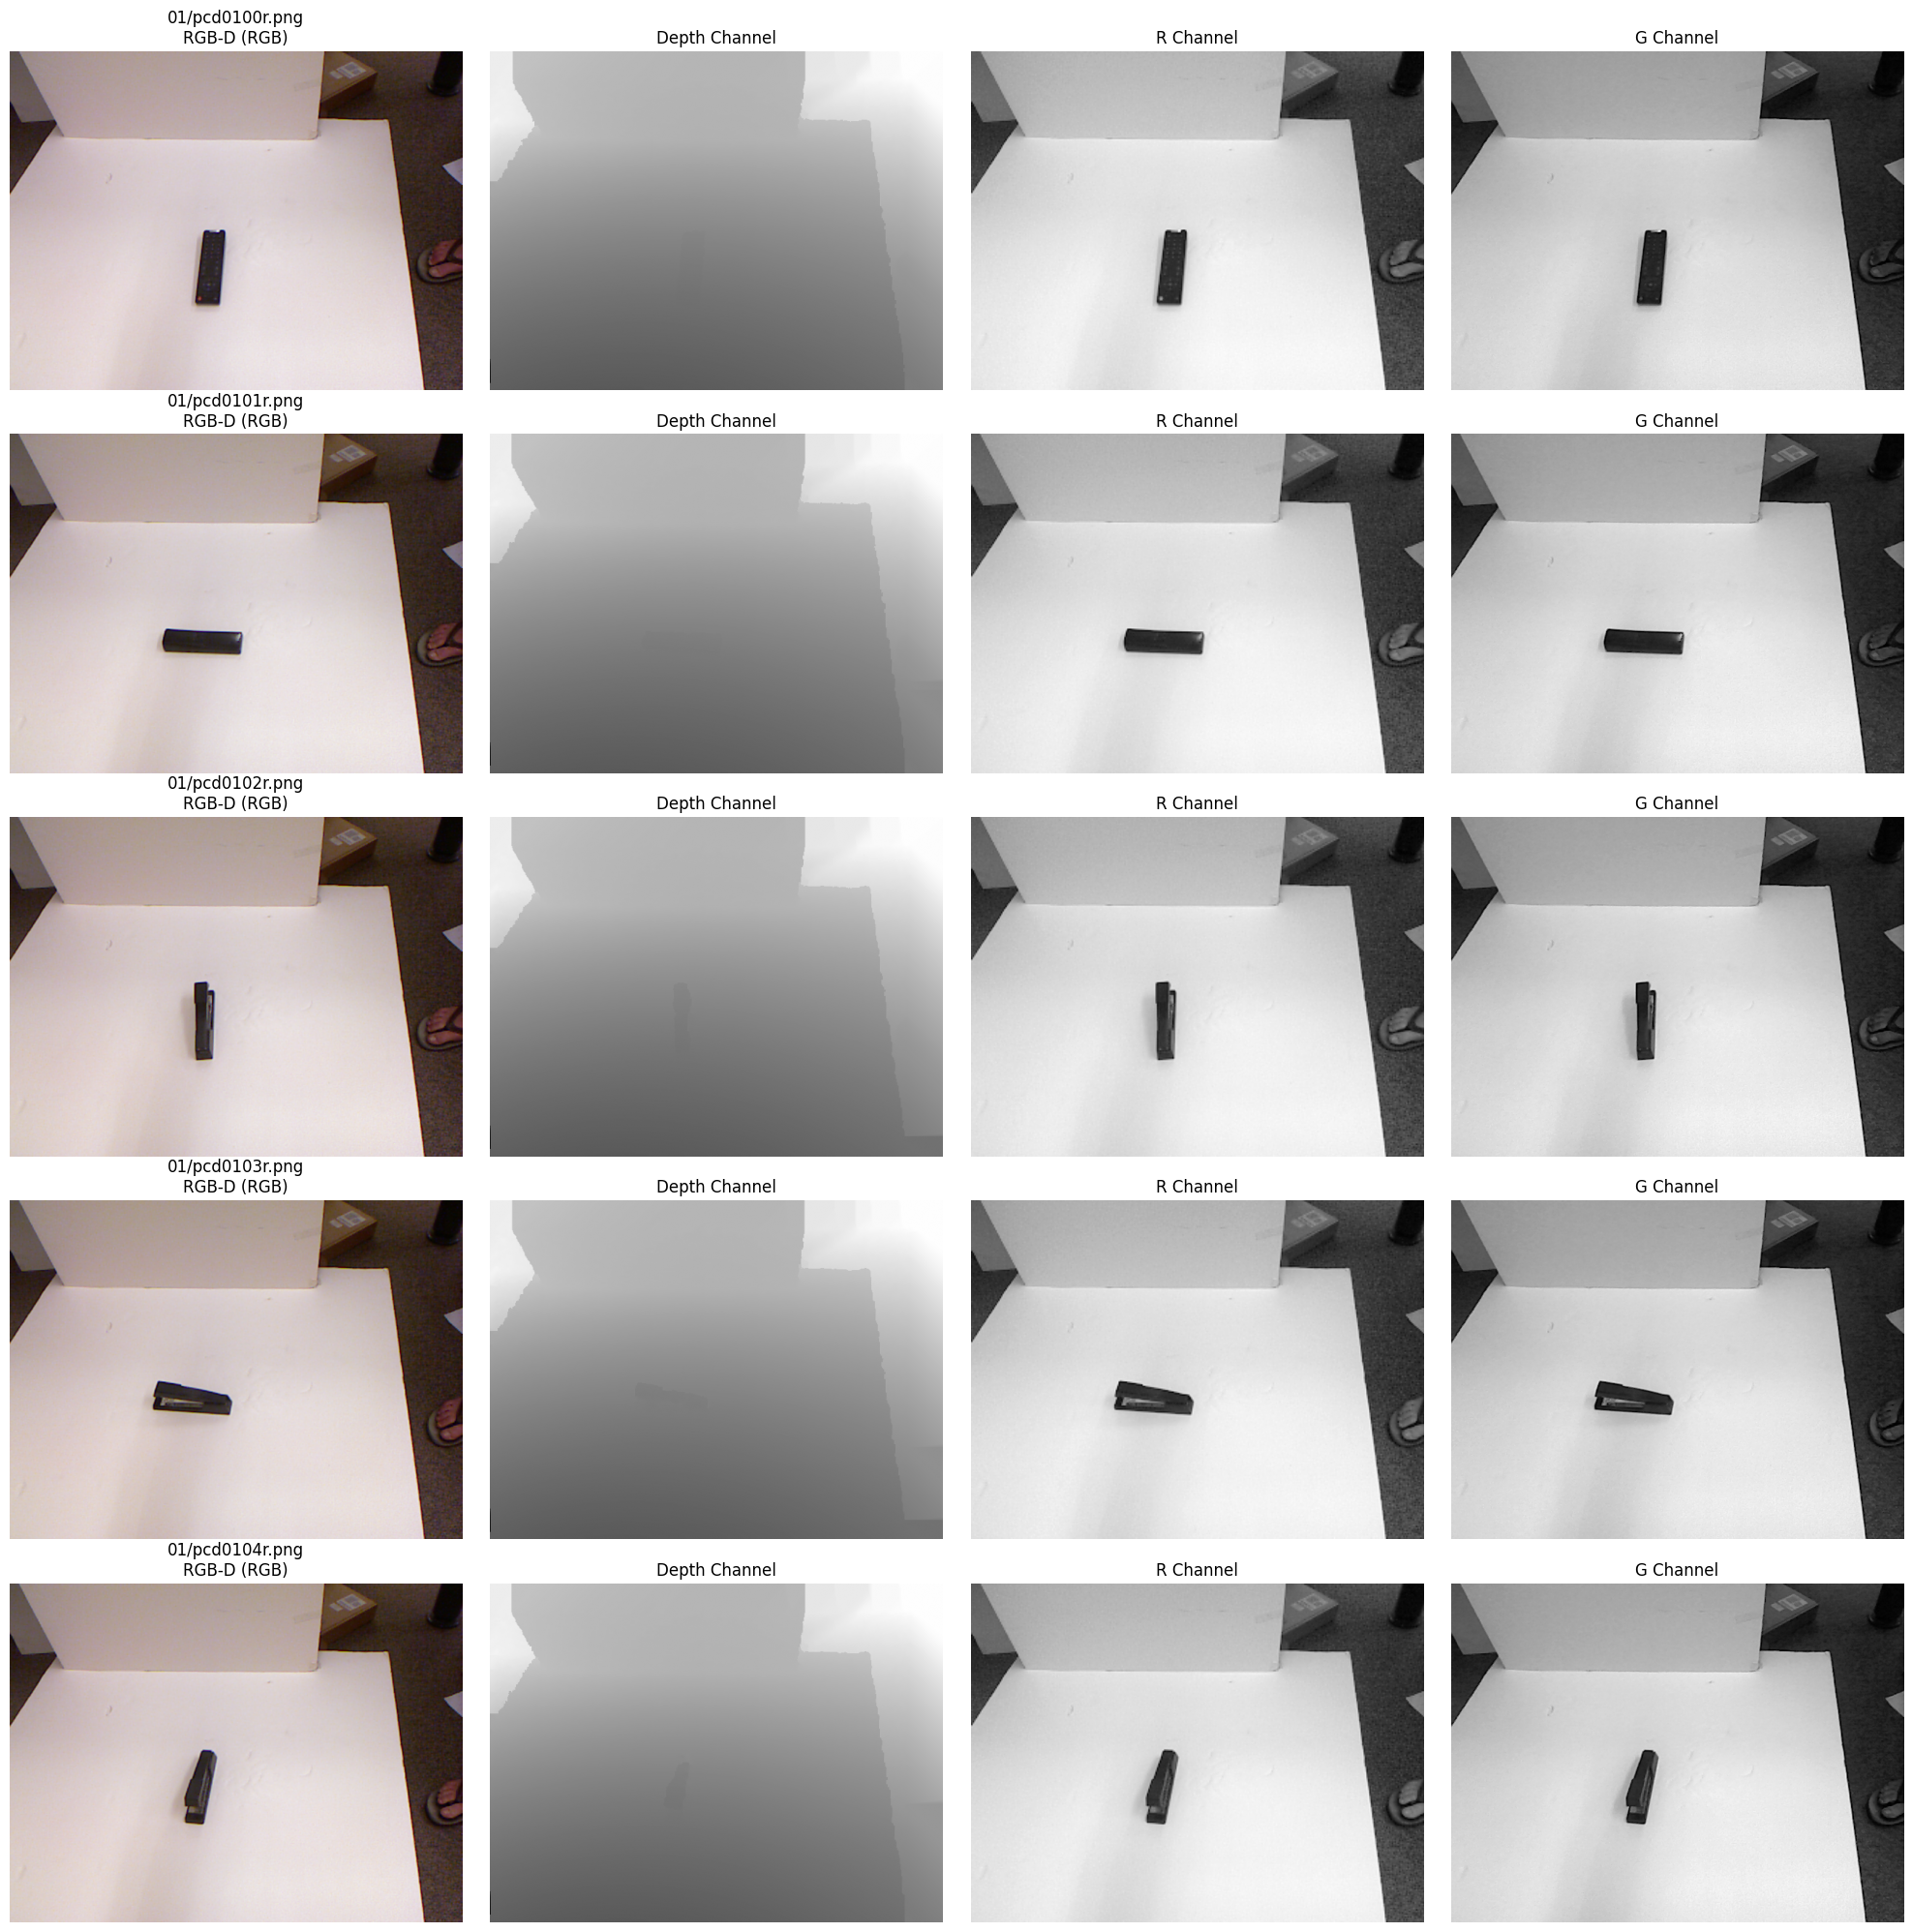

In [32]:
num_to_show = min(5, len(all_rgbd_images))
if num_to_show == 0:
    print("No RGB-D images to display.")
else:
    fig, axes = plt.subplots(num_to_show, 4, figsize=(20, 4 * num_to_show))


    if num_to_show == 1:
        axes = [axes]

    for i in range(num_to_show):
        sf, base_name, rgbd = all_rgbd_images[i]
        h, w, c = rgbd.shape


        rgb_part = rgbd[:, :, :3]
        depth_part = rgbd[:, :, 3]


        row_axes = axes[i]

        # 4-channel image's RGB part
        row_axes[0].imshow(rgb_part)
        row_axes[0].set_title(f"{sf}/{base_name}\nRGB-D (RGB)")
        row_axes[0].axis("off")

        # Depth channel
        row_axes[1].imshow(depth_part, cmap='gray')
        row_axes[1].set_title("Depth Channel")
        row_axes[1].axis("off")

        # R channel
        row_axes[2].imshow(rgb_part[:, :, 0], cmap='gray')
        row_axes[2].set_title("R Channel")
        row_axes[2].axis("off")

        # G channel
        row_axes[3].imshow(rgb_part[:, :, 1], cmap='gray')
        row_axes[3].set_title("G Channel")
        row_axes[3].axis("off")

    plt.tight_layout()
    plt.show()

In [33]:
def order_points(pts):
    """
    Reorders 4 points to the order:
    top-left, top-right, bottom-right, bottom-left.
    """
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    """
    Performs a perspective transform to extract a top-down view of the region.
    image: (H, W, C)
    pts: array of shape (4, 2)
    """
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

# Task 3:

In [34]:
def extract_subpatches_yuv_depth(base_dir):


    all_subpatch_features = []  # will store (yuv_patch, depth_patch)

    for sf in subfolders:
        folder_path = os.path.join(base_dir, sf)
        print(f"\n[INFO] Processing folder: {folder_path}")

        # Find all RGB files matching "*r.png"
        rgb_paths = glob.glob(os.path.join(folder_path, "*r.png"))
        rgb_paths.sort()

        for rgb_path in rgb_paths:
            # Derive the matching depth and annotation paths
            depth_path = rgb_path.replace("r.png", "d.tiff")
            cpos_path = rgb_path.replace("r.png", "cpos.txt")

            # Check if files exist
            if not os.path.exists(depth_path):
                print(f"  [Skipping] Depth not found for {rgb_path}")
                continue
            if not os.path.exists(cpos_path):
                print(f"  [Skipping] Positive annotation not found for {rgb_path}")
                continue

            # 1) Create the 4-channel RGB-D image
            rgbd_image = load_and_merge_rgb_depth(rgb_path, depth_path)
            if rgbd_image is None:
                print(f"  [Skipping] Failed to create RGB-D for {rgb_path}")
                continue

            # 2) Parse positive rectangles
            positive_rectangles = parse_rectangles(cpos_path)
            if not positive_rectangles:
                print(f"  [No Rectangles] {cpos_path}")
                continue

            # 3) Extract subpatches for each rectangle
            for rect in positive_rectangles:
                pts = np.array(rect, dtype="float32")
                subpatch = four_point_transform(rgbd_image, pts)  # shape: (H', W', 4)

                if subpatch.shape[2] != 4:
                    print("  [Warning] Subpatch is not 4-channel.")
                    continue

                # Convert first 3 channels to YUV
                # subpatch[:, :, :3] is assumed to be RGB (uint8)
                rgb_subpatch = subpatch[:, :, :3].astype(np.uint8)
                yuv_subpatch = cv2.cvtColor(rgb_subpatch, cv2.COLOR_RGB2YUV)

                # Extract depth channel (4th channel)
                depth_subpatch = subpatch[:, :, 3]

                # Store the result
                all_subpatch_features.append((yuv_subpatch, depth_subpatch))

    return all_subpatch_features


[INFO] Processing folder: /content/01
Skipping line with NaN values: NaN NaN

[INFO] Processing folder: /content/02

[INFO] Processing folder: /content/03

[INFO] Processing folder: /content/04

[INFO] Processing folder: /content/05

[INFO] Processing folder: /content/06

[INFO] Processing folder: /content/07

[INFO] Processing folder: /content/08

[INFO] Processing folder: /content/09

[INFO] Processing folder: /content/10

[INFO] Total subpatches extracted: 5110


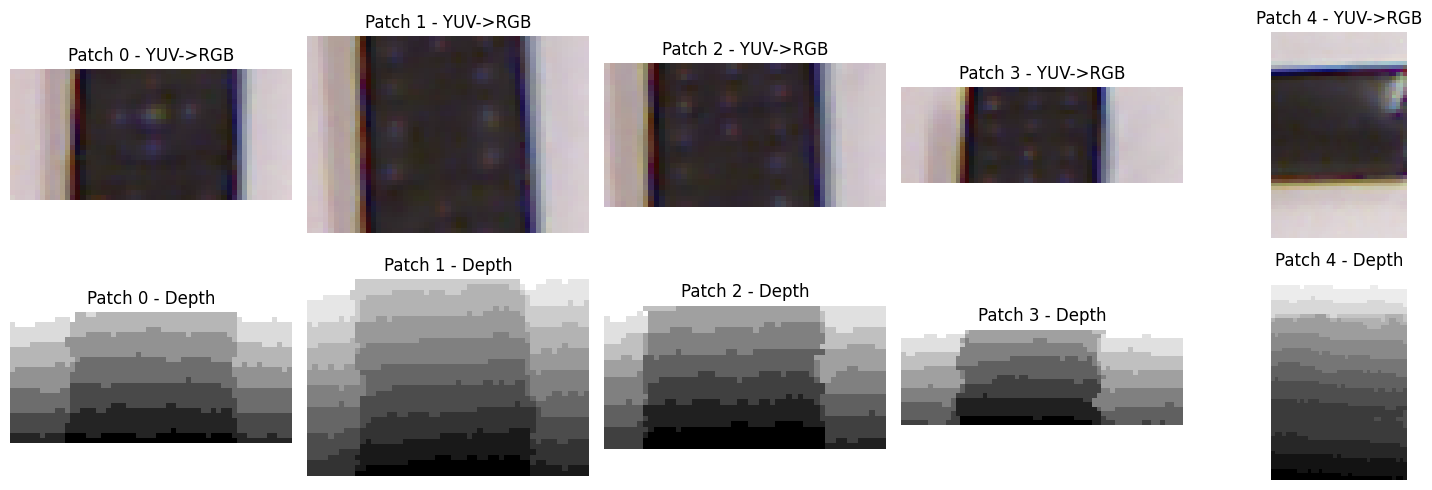

In [35]:
all_features = extract_subpatches_yuv_depth(base_dir)
print(f"\nTotal subpatches extracted: {len(all_features)}")


num_to_show = min(5, len(all_features))
if num_to_show == 0:
    print("No subpatches to display.")
else:
    plt.figure(figsize=(15, 5))
    for i in range(num_to_show):
        yuv_patch, depth_patch = all_features[i]

        # Convert YUV back to RGB for display
        rgb_patch = cv2.cvtColor(yuv_patch, cv2.COLOR_YUV2RGB)

        plt.subplot(2, num_to_show, i+1)
        plt.imshow(rgb_patch)
        plt.title(f"Patch {i} - YUV->RGB")
        plt.axis("off")

        plt.subplot(2, num_to_show, i+1+num_to_show)
        plt.imshow(depth_patch, cmap='gray')
        plt.title(f"Patch {i} - Depth")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Task 4
### PCA Whitening

In [36]:
def pca_whiten_depth_patches(all_features):

    depth_patches = [depth for (_, depth) in all_features]
    if len(depth_patches) == 0:
        print("[WARNING] No depth patches found. Returning empty list.")
        return [], None

    target_shape = depth_patches[0].shape

    resized_patches = []
    for dp in depth_patches:
        if dp.shape != target_shape:
            dp_resized = cv2.resize(dp, (target_shape[1], target_shape[0]))
            resized_patches.append(dp_resized)
        else:
            resized_patches.append(dp)


    X = np.array([patch.flatten() for patch in resized_patches])  # shape: (num_patches, H*W)

    print("Feature matrix shape:", X.shape)

    # Apply PCA with whitening
    pca = PCA(whiten=True)
    X_whitened = pca.fit_transform(X)  # shape: (num_patches, n_components)

    X_reconstructed = pca.inverse_transform(X_whitened)  # shape: (num_patches, H*W)

    # 6) Reshape each row back to (H, W)
    whitened_patches = [row.reshape(target_shape) for row in X_reconstructed]

    return whitened_patches, pca

In [37]:
def pca_whitening(all_features):
    whitened_patches, pca = pca_whiten_depth_patches(all_features)
    if not whitened_patches:
        print("No whitened patches to display.")
        return

    # Display original and whitened patches
    num_to_show = min(5, len(whitened_patches))
    plt.figure(figsize=(15, 5))
    for i in range(num_to_show):
        original_depth = all_features[i][1]  # depth_patch from (yuv, depth)
        whitened_depth = whitened_patches[i]

        target_shape = whitened_depth.shape
        if original_depth.shape != target_shape:
            original_depth_resized = cv2.resize(original_depth, (target_shape[1], target_shape[0]))
        else:
            original_depth_resized = original_depth

        # original
        plt.subplot(2, num_to_show, i+1)
        plt.imshow(original_depth_resized, cmap='gray')
        plt.title(f"Original Depth {i}")
        plt.axis("off")

        # whitened
        plt.subplot(2, num_to_show, i+1+num_to_show)
        plt.imshow(whitened_depth, cmap='gray')
        plt.title(f"Whitened Depth {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Feature matrix shape: (5110, 1456)


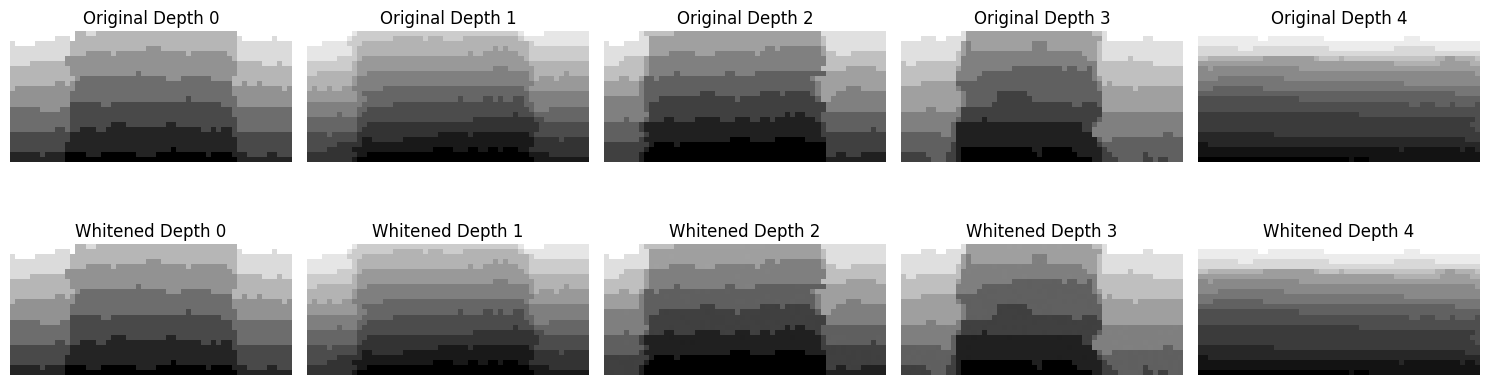

In [38]:
pca_whitening(all_features)

# Task 5


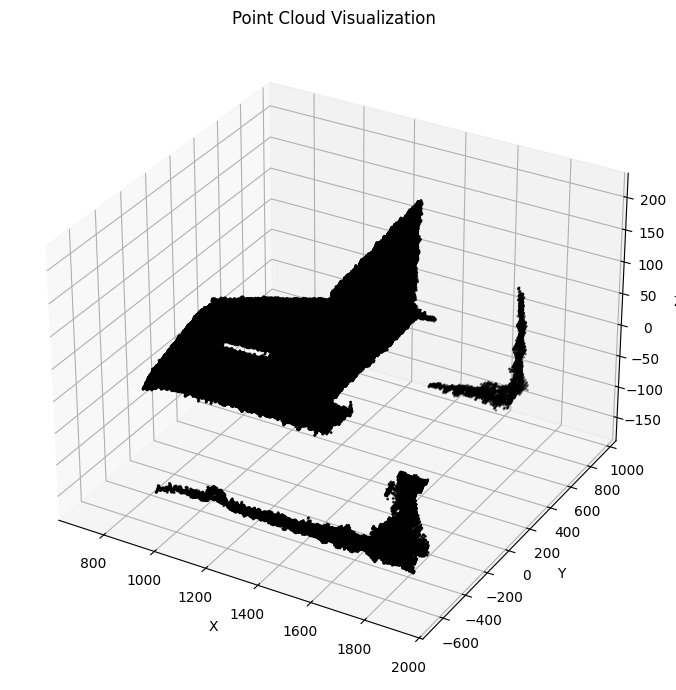

In [39]:
points = []

with open("/content/01/pcd0100.txt", "r") as file:
    lines = file.readlines()

# Skip header until we find 'DATA ascii'
for idx, line in enumerate(lines):
    if line.strip().lower() == "data ascii":
        data_start = idx + 1
        break

# Read XYZ from the rest of the lines
for line in lines[data_start:]:
    values = line.strip().split()
    if len(values) >= 3:
        x, y, z = map(float, values[0:3])
        points.append([x, y, z])

points = np.array(points)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='black')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Point Cloud Visualization')

plt.tight_layout()
plt.show()
